## **Lab 1: Predicting the diagnosis of Azheimer’s disease, and mild cognitive impairment using 3D CNN model and brain 18F-FDG PET brain scans**

Welcome to the first lab of the AI for Health Course.

Below you can see the instructions to proceed with the needed tasks. You should complete the implementation of the functions mentioned below.

For the lab submission, you should write a report explaining your implementation and showing the results .
You also are required to upload the code with the report.

Have fun :)

### References
A 3D deep learning model to predict the diagnosis of dementia with Lewy bodies, Alzheimer’s disease, and mild cognitive impairment using brain 18F-FDG PET: https://link.springer.com/article/10.1007/s00259-021-05483-0

### We start by importing some required packages:
*   tensorflow
*   keras
*   nibabel
*   numpy
*   matplotlib
*   scikit-learn

In [3]:
!pip install pytorch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\danie\AppData\Local\Temp\pip-install-hibjf0he\pytorch_8ed6c49117a04e0fae32aed71b6769fa\setup.py", line 15, in <module>
      raise Exception(message)
  Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib 

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!python --version

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU detected.")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Python 3.11.5
cuda:0
GPU is available.


If you are going to use school servers, some hints to avoid resource collision :)

If you are using Google Colab, then you need to mount your google drive to be able to access the brain scans data

Visualizing one example out of the data shared for the lab

(79, 95, 79)


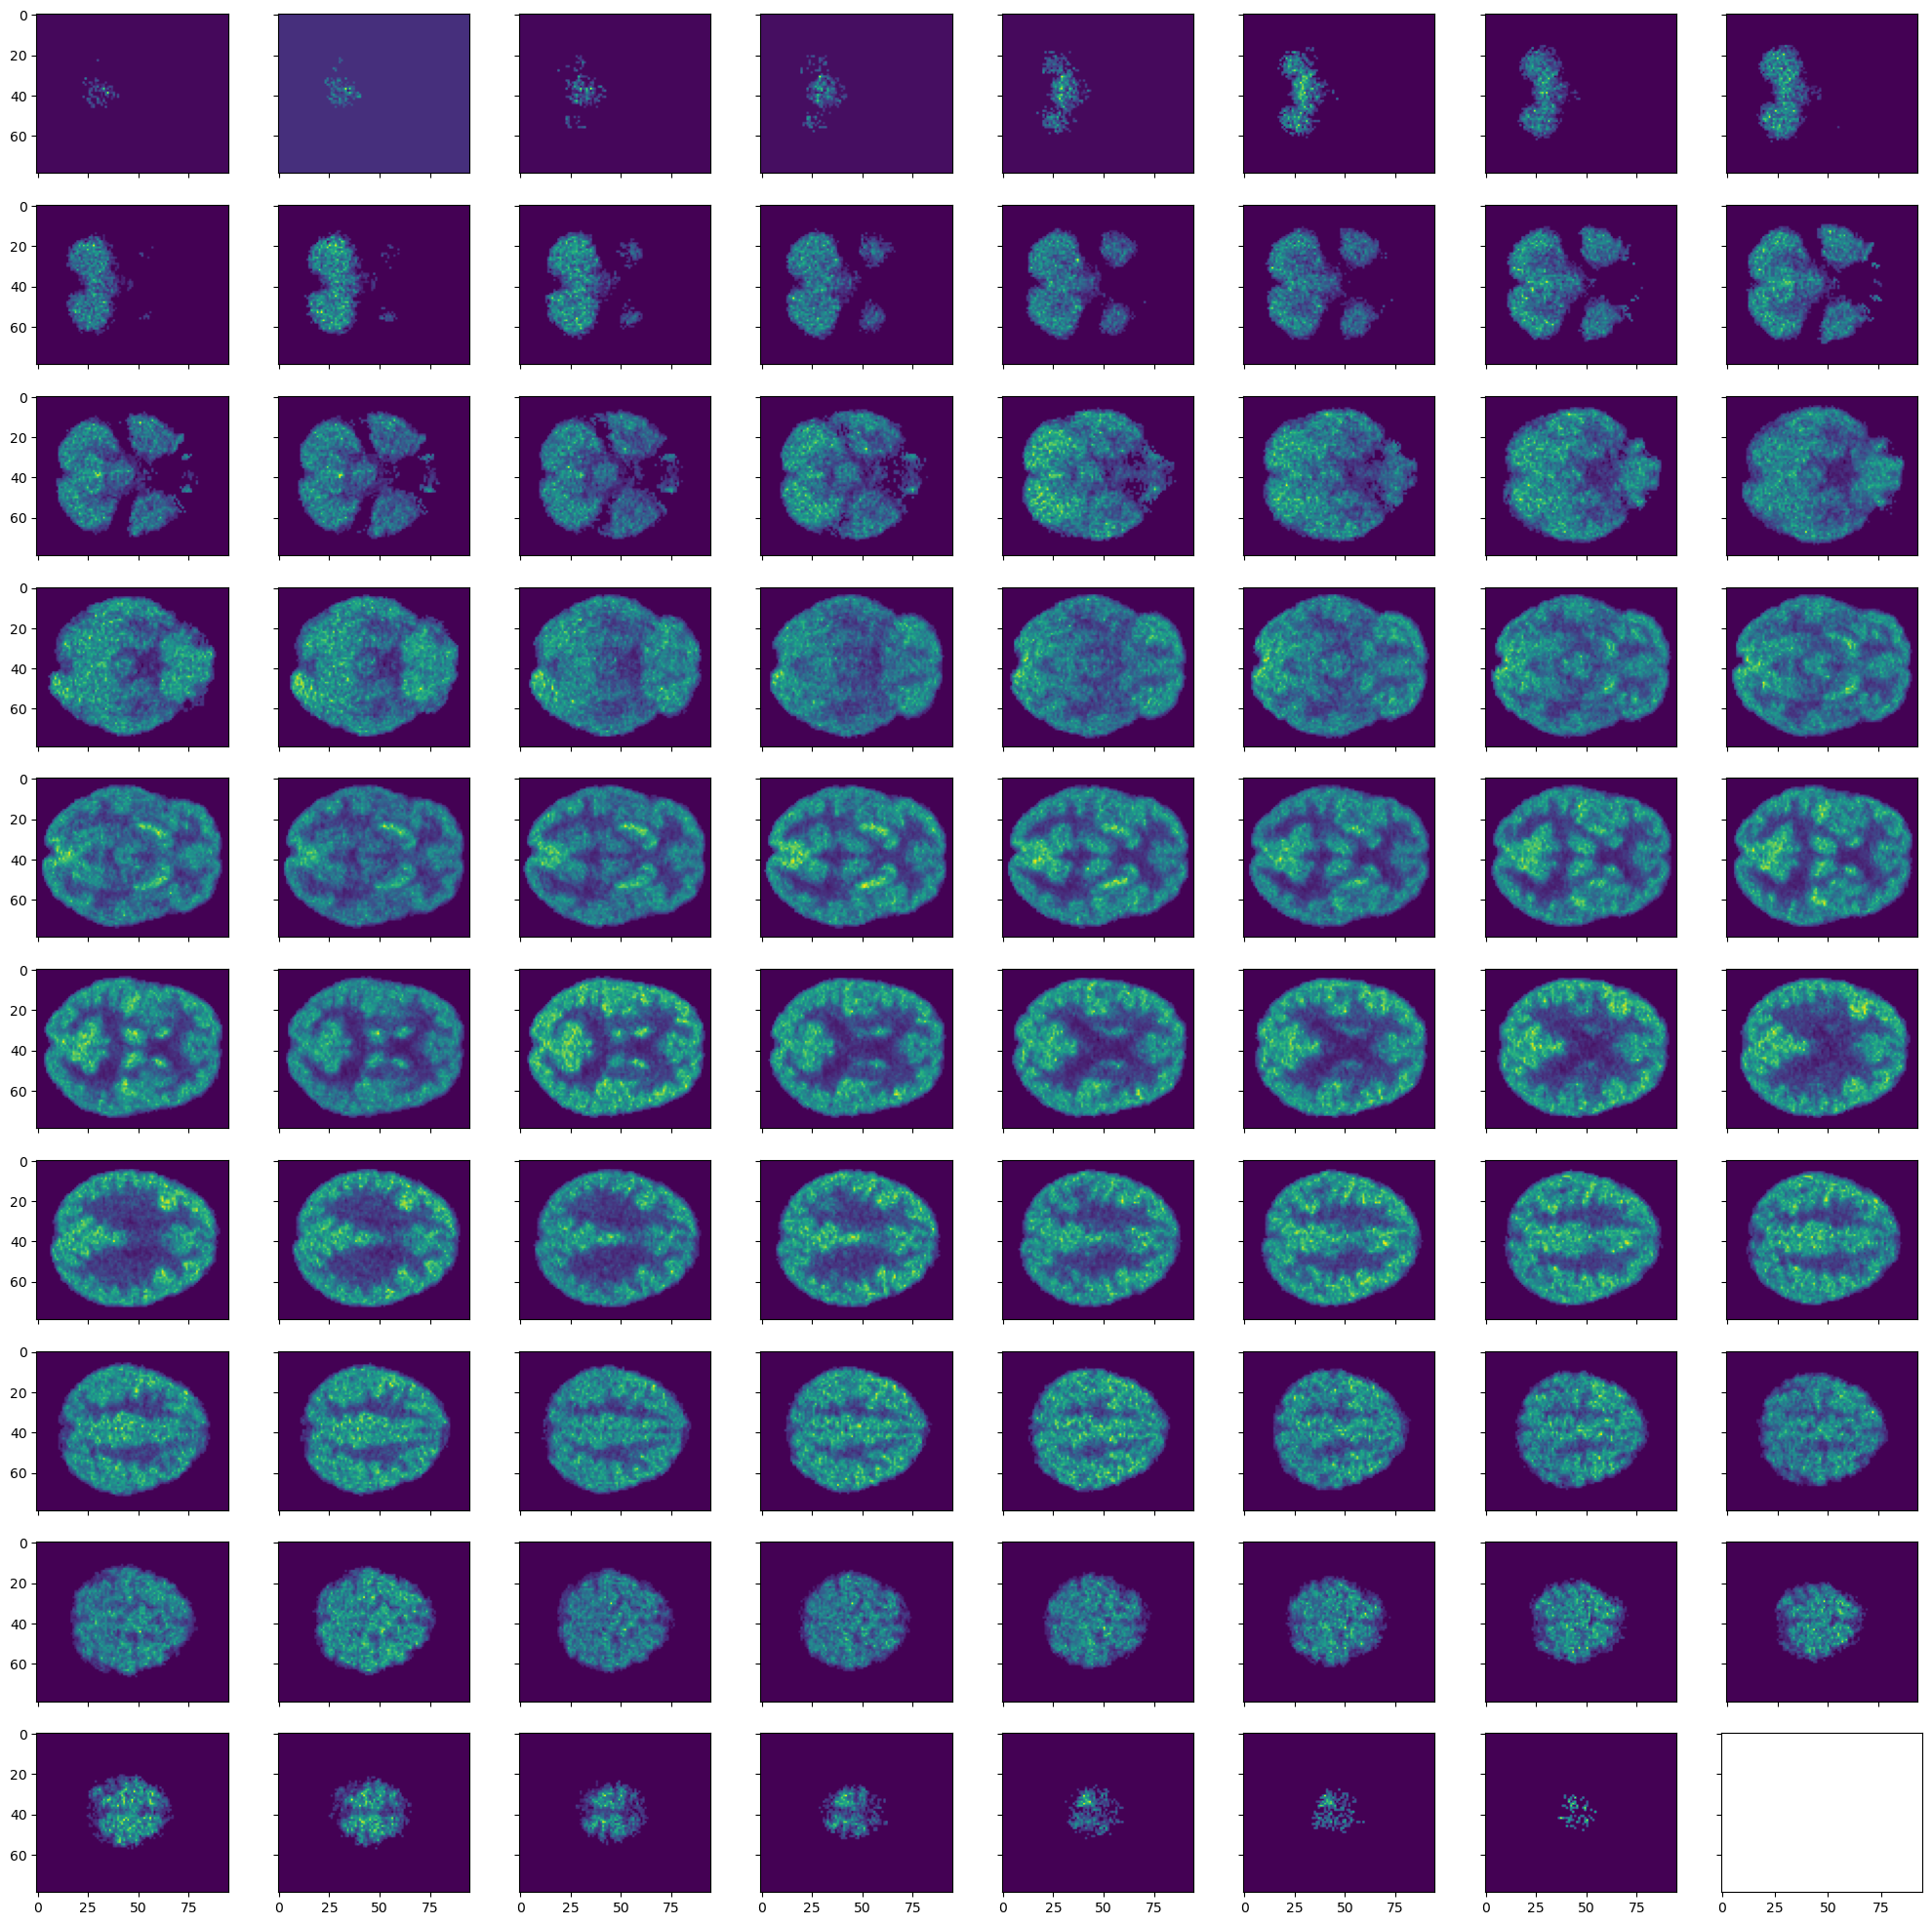

In [6]:
#here I'm visualizing a scan, so that you can see the different slices of the brain
local_normal = 'C:/Users/Danie/OneDrive/Dokument/SKOLA/HÄLSA 1/lab1_data/lab1_data/AD/AD/AD_ADNI_2489.nii'
pet_img=nib.load(local_normal).get_fdata()
print(pet_img.shape)

fig, axs = plt.subplots(10,8, figsize = (25, 25), sharex='all', sharey='all')
for i in range (10):
    for j in range (8):
        index = i*8 + j
        axs[i,j].imshow(pet_img[:,:,index])

        if index+1 > 78:
            break

## **Task1**


*   Load images and perform intensity normalization



In [7]:
from sklearn import preprocessing

dim_x = 79
dim_y = 95
dim_z = 79

def intensity_normalize(img):
    data_flat = img.flatten()
    data_scaled = preprocessing.scale(data_flat)
    data_scaled = data_scaled.reshape(img.shape)
    return data_scaled

def load_all_nii_data(path, filenames, category):
    data = np.zeros((len(filenames), dim_x, dim_y, 60, 1))
    labels = np.full(len(filenames), category)

    for i, filename in enumerate(filenames):
        file_path = os.path.join(path, filename)
        img = nib.load(file_path).get_fdata()

        start_index = (img.shape[2] - dim_z) // 2

        img = img[:dim_x, :dim_y, start_index+10:start_index+dim_z-9]

        img_normalized = intensity_normalize(img)

        data[i, :, :, :, 0] = img_normalized

    return data, labels

ad_path = 'C:/Users/Danie/OneDrive/Dokument/SKOLA/HÄLSA 1/lab1_data/lab1_data/AD/AD/'
cn_path = 'C:/Users/Danie/OneDrive/Dokument/SKOLA/HÄLSA 1/lab1_data/lab1_data/CN/CN/' 
mci_path = 'C:/Users/Danie/OneDrive/Dokument/SKOLA/HÄLSA 1/lab1_data/lab1_data/MCI/MCI/'

ad_files = os.listdir(ad_path)
cn_files = os.listdir(cn_path)
mci_files = os.listdir(mci_path)

cn_data, cn_labels = load_all_nii_data(cn_path, cn_files, 0) 
ad_data, ad_labels = load_all_nii_data(ad_path, ad_files, 1) 
mci_data, mci_labels = load_all_nii_data(mci_path, mci_files, 2)

all_data = np.concatenate((cn_data, ad_data, mci_data), axis=0)
all_labels = np.concatenate((cn_labels, ad_labels, mci_labels), axis=0)

print(all_data.shape)
print(all_labels.shape)

(300, 79, 95, 60, 1)
(300,)


In [8]:
unique_labels = np.unique(all_labels)
print("Unique Labels:", unique_labels)

Unique Labels: [0 1 2]


Visualizing Sample: 0 Label: 0


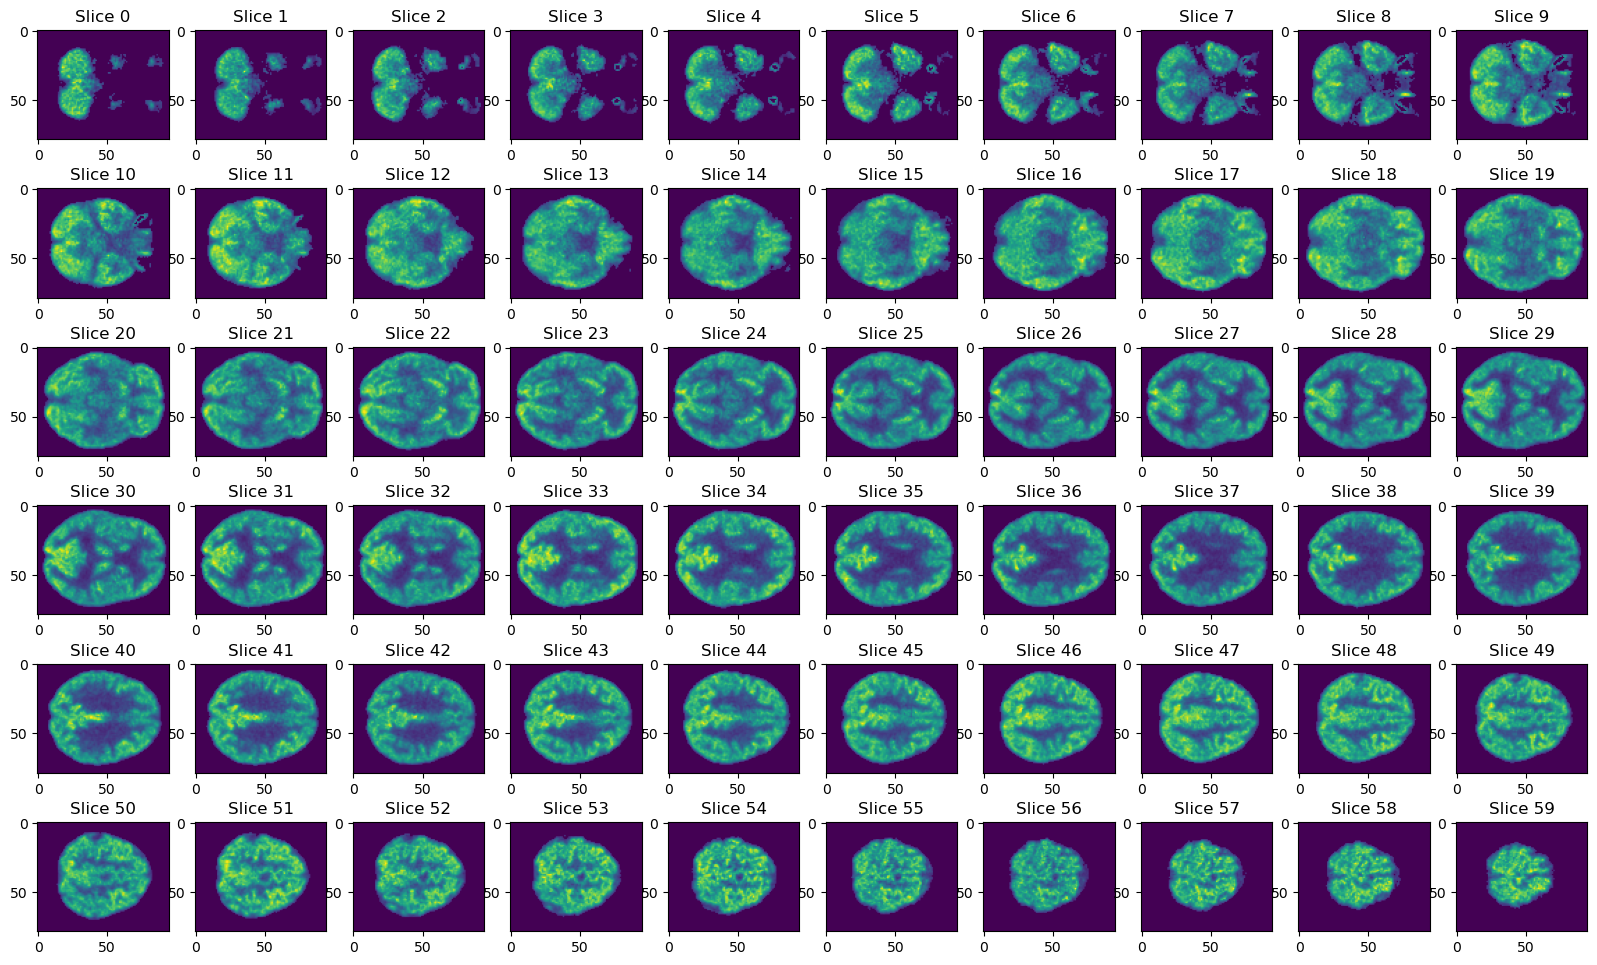

Visualizing Sample: 1 Label: 0


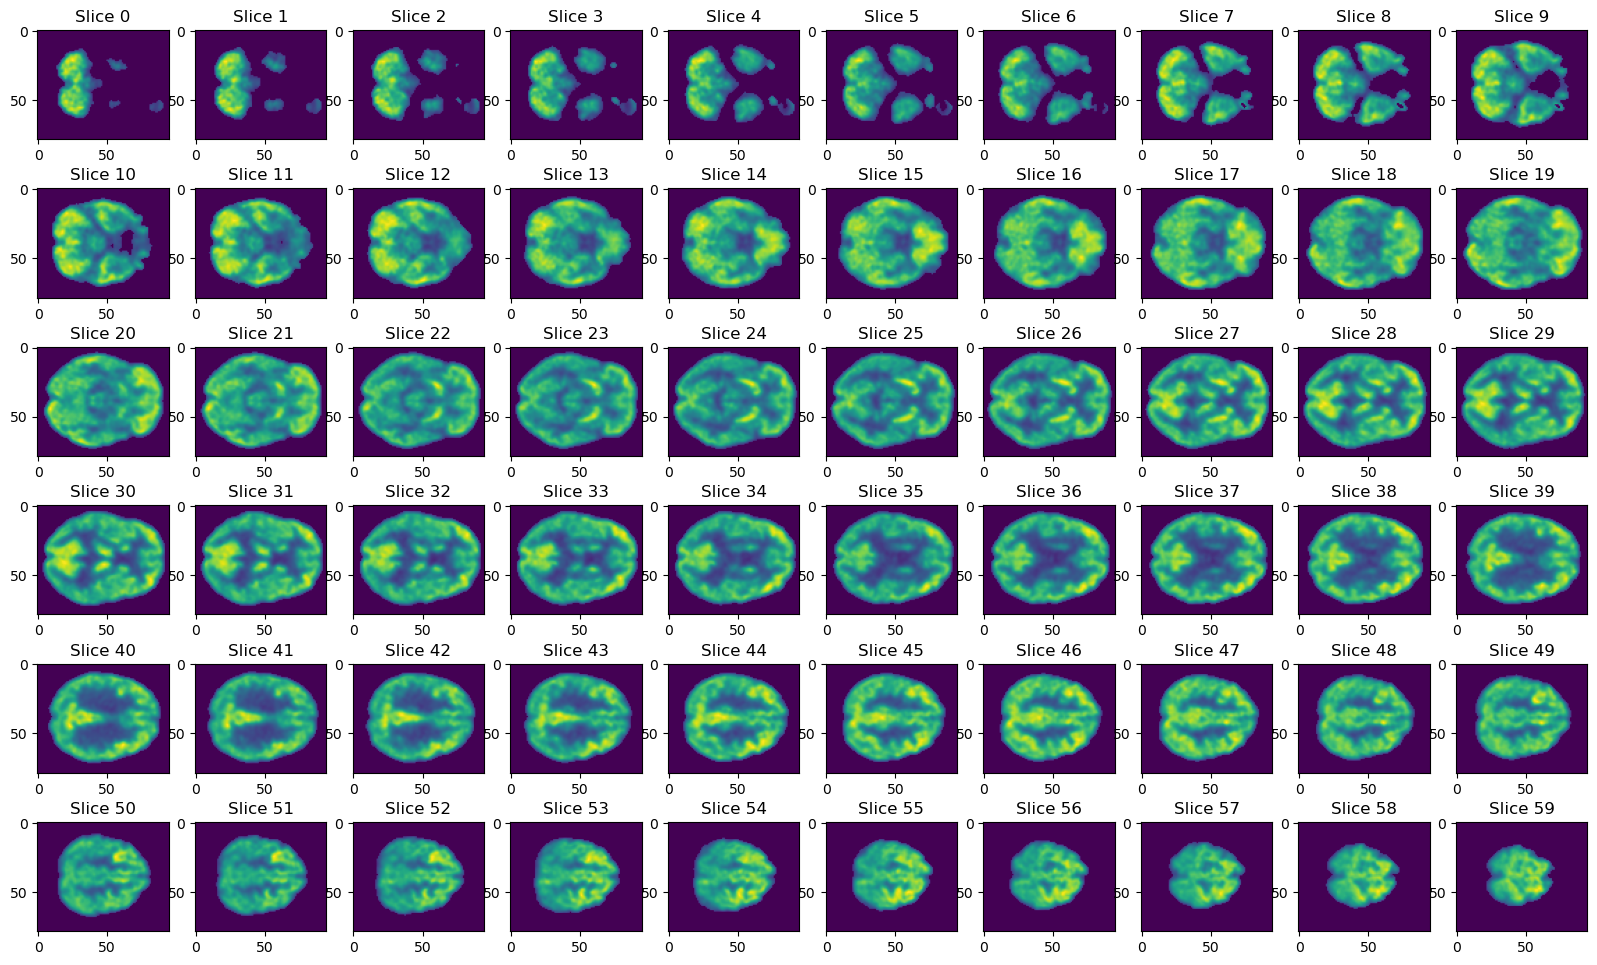

Visualizing Sample: 2 Label: 0


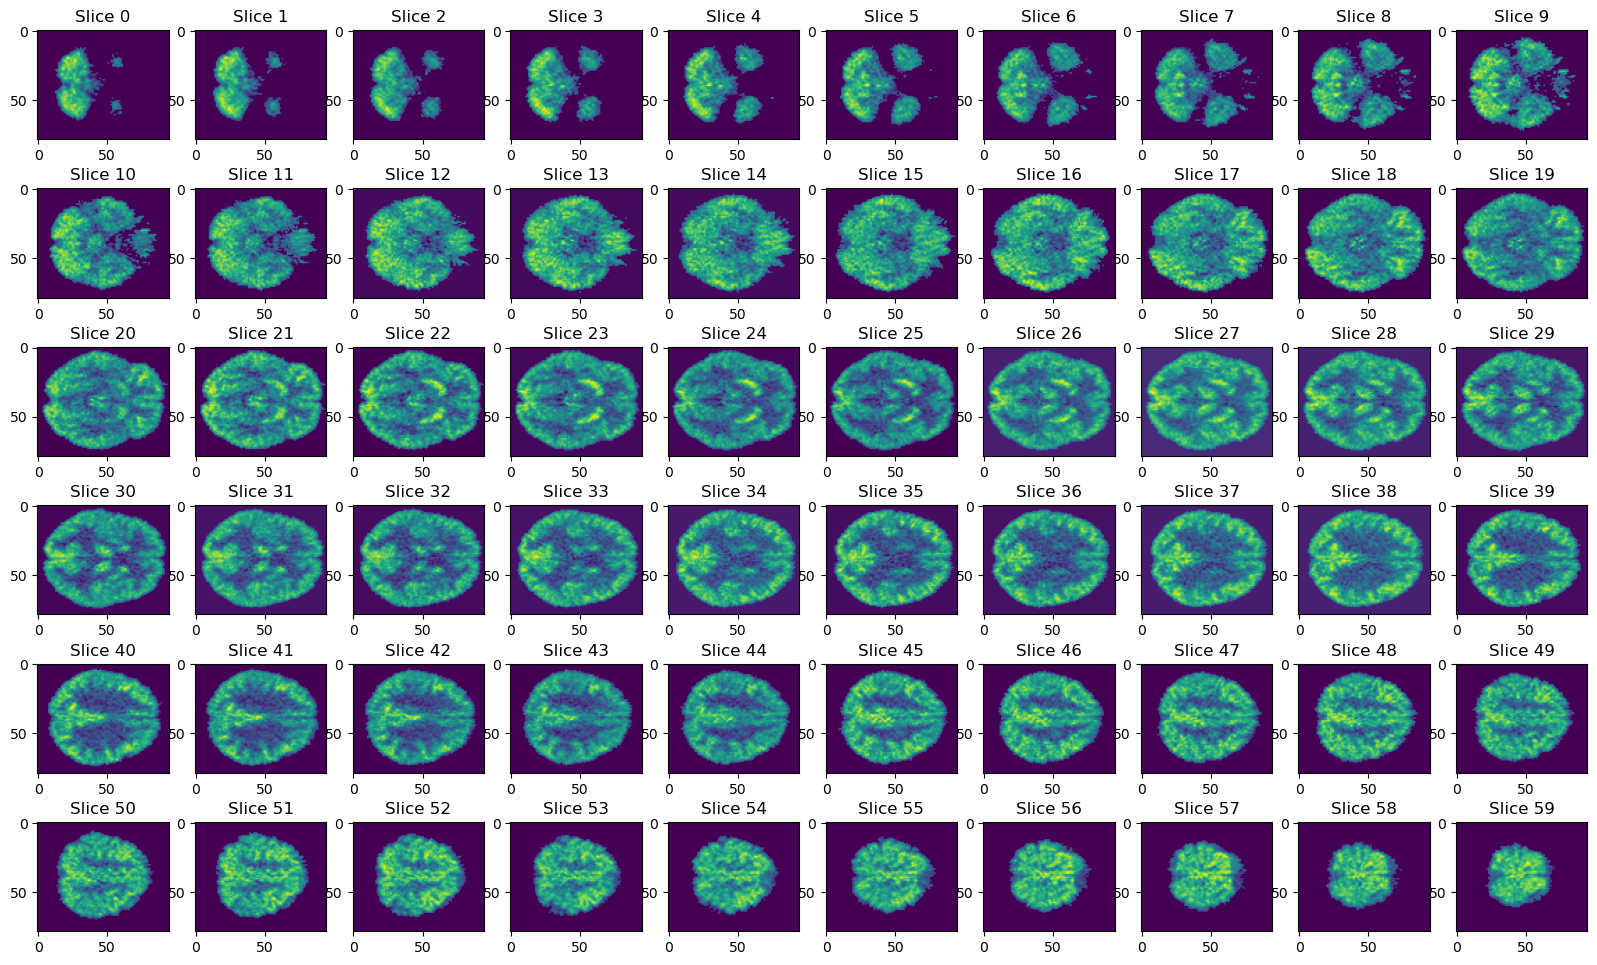

Visualizing Sample: 3 Label: 0


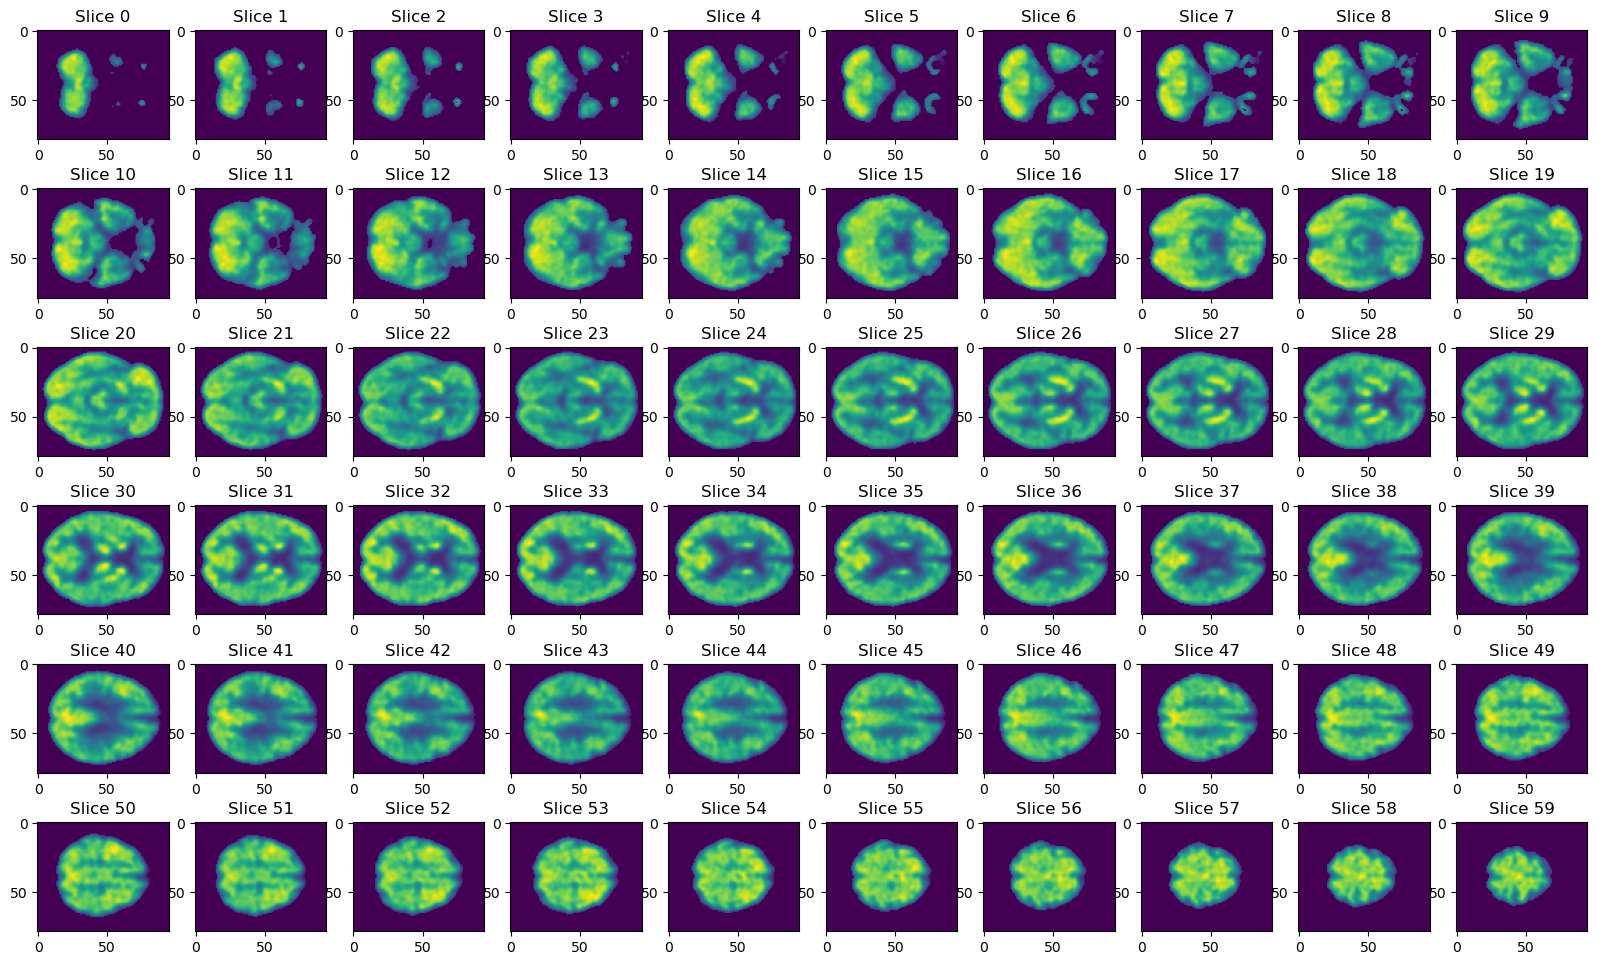

Visualizing Sample: 4 Label: 0


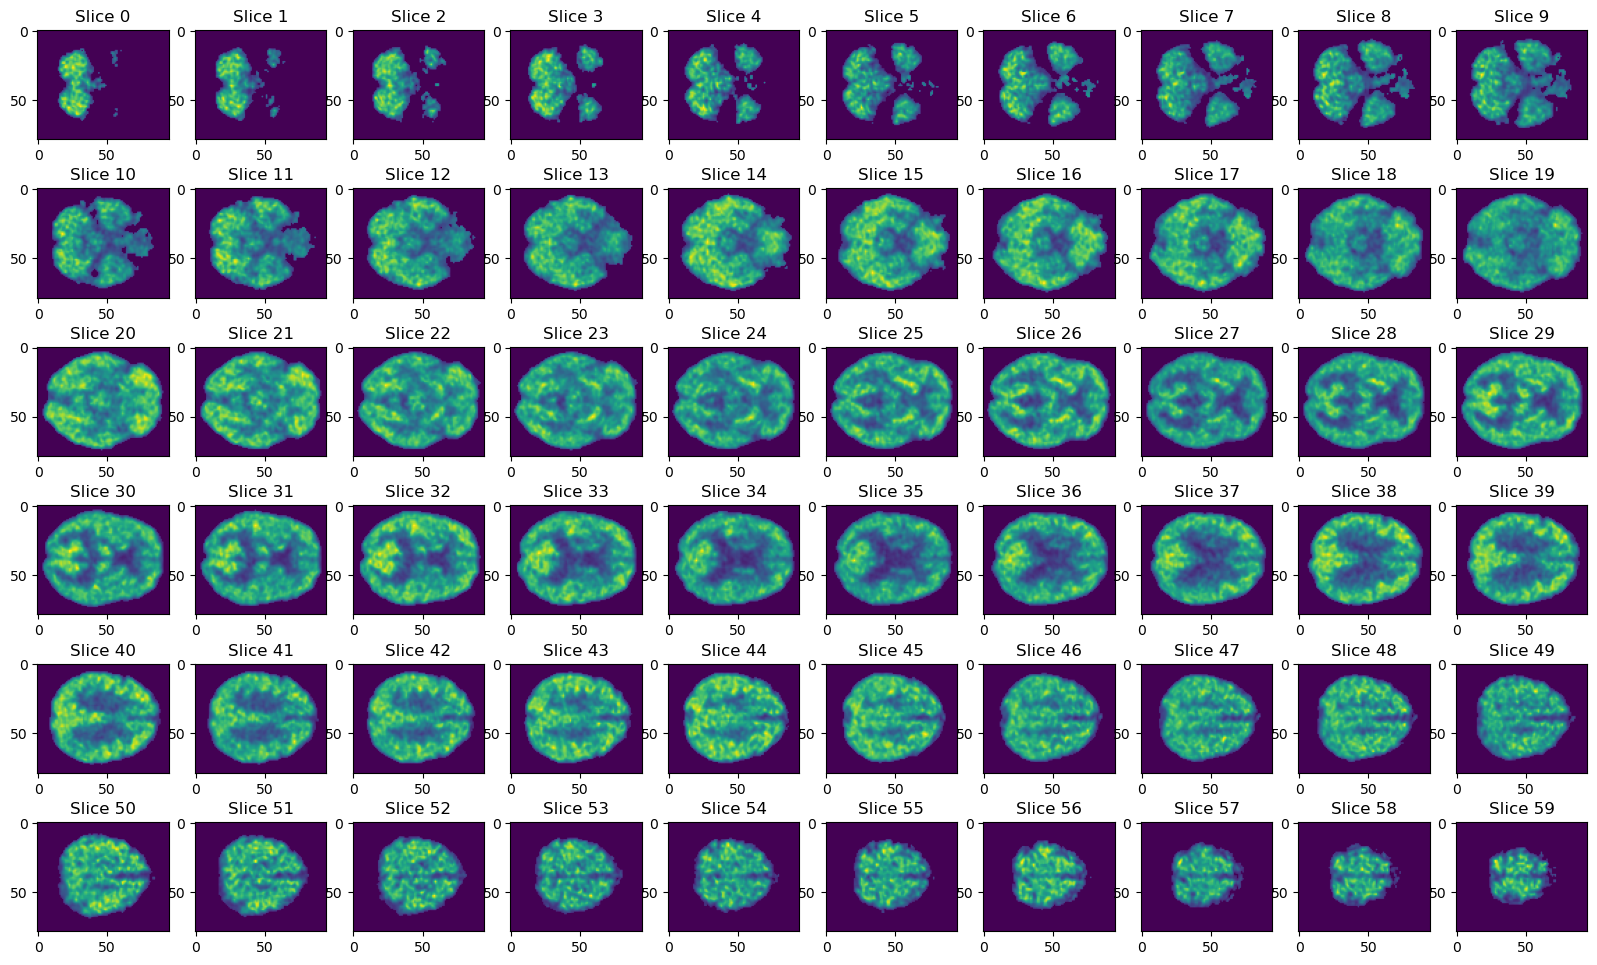

In [9]:
# Visualize all slices of the first 5 samples after normalization
for sample_index in range(5):
    print("Visualizing Sample:", sample_index, "Label:", all_labels[sample_index])
    fig, axs = plt.subplots(6, 10, figsize=(20, 12))

    for i in range(6):
        for j in range(10):
            
            slice_index = i * 10 + j
            axs[i, j].imshow(all_data[sample_index, :, :, slice_index, 0], cmap='viridis') 
            axs[i, j].set_title(f"Slice {slice_index}")

    plt.show()

## **Task2**


*   Split your data into training and testing datasets



In [10]:
# here write the code to split the data into train and test datasets
# leave 10% of your data for testing
def split_data(images, labels, ratio=0.9):
    num_samples = len(images)

    indices = np.random.permutation(num_samples)

    split_index = int(num_samples * ratio)
    
    training_indices, test_indices = indices[:split_index], indices[split_index:]
    training_data, test_data = images[training_indices], images[test_indices]
    training_labels, test_labels = labels[training_indices], labels[test_indices]
    
    return training_data, test_data, training_labels, test_labels

training_data, test_data, training_labels, test_labels = split_data(all_data, all_labels, ratio=0.9)

print("Training data shape:", training_data.shape)
print("Training labels shape:", training_labels.shape)
print("Testing data shape:", test_data.shape)
print("Testing labels shape:", test_labels.shape)

unique_labels = np.unique(test_labels)
print("Unique Labels in Test Data:", unique_labels)
unique_labels = np.unique(training_labels)
print("Unique Labels in Training Data:", unique_labels)

Training data shape: (270, 79, 95, 60, 1)
Training labels shape: (270,)
Testing data shape: (30, 79, 95, 60, 1)
Testing labels shape: (30,)
Unique Labels in Test Data: [0 1 2]
Unique Labels in Training Data: [0 1 2]


## **Task3**


*   Define your 3D VGG model



In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VGG3DComplex(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG3DComplex, self).__init__()
        self.conv1_1 = nn.Conv3d(79, 8, kernel_size=(3, 3, 3), padding=1)
        self.conv1_2 = nn.Conv3d(8, 8, kernel_size=(3, 3, 3), padding=1)
        self.maxpool1 = nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1)
        self.batchnorm1 = nn.BatchNorm3d(8)

        self.conv2_1 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), padding=1)
        self.conv2_2 = nn.Conv3d(16, 16, kernel_size=(3, 3, 3), padding=1)
        self.maxpool2 = nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1)
        self.batchnorm2 = nn.BatchNorm3d(16)

        self.conv3_1 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1)
        self.conv3_2 = nn.Conv3d(32, 32, kernel_size=(3, 3, 3), padding=1)
        self.maxpool3 = nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1)
        self.batchnorm3 = nn.BatchNorm3d(32)

        self.conv4_1 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1)
        self.conv4_2 = nn.Conv3d(64, 64, kernel_size=(3, 3, 3), padding=1)
        self.maxpool4 = nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1)
        self.batchnorm4 = nn.BatchNorm3d(64)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128, 16) 
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(16, 16)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool1(x)
        x = self.batchnorm1(x)

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool2(x)
        x = self.batchnorm2(x)

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.maxpool3(x)
        x = self.batchnorm3(x)

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.maxpool4(x)
        x = self.batchnorm4(x)

        x = self.flatten(x)

        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)

        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.softmax(x)

        return x


## **Task4**


*   Model training


The next step is to perform the cross-validation using k=5 for the number of folds

Here is some guidance regarding optimizer and early stopping conditions

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=0, patience=5, mode='auto')

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=0, patience=10, mode='auto')

Keep in mind to save some disk space, keep the model achieving the highest validation accuracy in each KFCV round

In [57]:
from torch.utils.data import Subset, ConcatDataset
from sklearn.model_selection import KFold
import copy

num_epochs = 150
num_classes = 3
batch_size = 128
k_folds = 5
best_acc = 0.0

kfold = KFold(n_splits=k_folds, shuffle=True)

val_data = list(zip(test_data, test_labels))
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

for fold, (train_ids, _) in enumerate(kfold.split(list(zip(training_data, training_labels)))): 
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_data_subset = Subset(training_data, train_ids)
    train_labels_subset = Subset(training_labels, train_ids)
    
    train_data = list(zip(train_data_subset, train_labels_subset))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    model = VGG3DComplex(num_classes=num_classes)
    model = model.double()
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01) 

    early_stopping_patience = 10
    early_stopping_counter = 0
    best_val_acc = 0.0 

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0  
        total_data = len(train_data)

        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            targets = targets.long()
            inputs = inputs.double()
            inputs, targets = inputs.to(device), targets.to(device)  
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        average_train_loss = total_train_loss / total_data

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, targets = data
                inputs = inputs.double() 
                targets = targets.long()
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        
        val_acc = 100.0 * correct / total
        average_val_loss = val_loss / len(val_data)
        print(f'fold {fold} and epoch {epoch+1}: Train Loss: {average_train_loss:.4f} | Val Loss: {average_val_loss:.4f} | Val Acc: {val_acc}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc  
            early_stopping_counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)

    if best_val_acc > best_acc:
        best_acc = best_val_acc 
        torch.save(model.state_dict(), f'model_fold_{fold}.pth')

print(f'Best Validation Acc: {best_acc}%')

FOLD 0
--------------------------------
fold 0 and epoch 1: Train Loss: 0.0102 | Val Loss: 0.0368 | Val Acc: 33.333333333333336%
fold 0 and epoch 2: Train Loss: 0.0102 | Val Loss: 0.0369 | Val Acc: 30.0%
fold 0 and epoch 3: Train Loss: 0.0102 | Val Loss: 0.0374 | Val Acc: 26.666666666666668%
fold 0 and epoch 4: Train Loss: 0.0100 | Val Loss: 0.0398 | Val Acc: 26.666666666666668%
fold 0 and epoch 5: Train Loss: 0.0098 | Val Loss: 0.0425 | Val Acc: 26.666666666666668%
fold 0 and epoch 6: Train Loss: 0.0097 | Val Loss: 0.0428 | Val Acc: 26.666666666666668%
fold 0 and epoch 7: Train Loss: 0.0096 | Val Loss: 0.0428 | Val Acc: 26.666666666666668%
fold 0 and epoch 8: Train Loss: 0.0094 | Val Loss: 0.0428 | Val Acc: 26.666666666666668%
fold 0 and epoch 9: Train Loss: 0.0094 | Val Loss: 0.0428 | Val Acc: 26.666666666666668%
fold 0 and epoch 10: Train Loss: 0.0090 | Val Loss: 0.0428 | Val Acc: 26.666666666666668%
fold 0 and epoch 11: Train Loss: 0.0089 | Val Loss: 0.0428 | Val Acc: 26.6666666666

fold 0 and epoch 98: Train Loss: 0.0075 | Val Loss: 0.0371 | Val Acc: 43.333333333333336%
fold 0 and epoch 99: Train Loss: 0.0074 | Val Loss: 0.0383 | Val Acc: 40.0%
fold 0 and epoch 100: Train Loss: 0.0077 | Val Loss: 0.0383 | Val Acc: 40.0%
fold 0 and epoch 101: Train Loss: 0.0073 | Val Loss: 0.0373 | Val Acc: 43.333333333333336%
fold 0 and epoch 102: Train Loss: 0.0075 | Val Loss: 0.0361 | Val Acc: 46.666666666666664%
fold 0 and epoch 103: Train Loss: 0.0074 | Val Loss: 0.0328 | Val Acc: 56.666666666666664%
fold 0 and epoch 104: Train Loss: 0.0070 | Val Loss: 0.0339 | Val Acc: 53.333333333333336%
fold 0 and epoch 105: Train Loss: 0.0068 | Val Loss: 0.0384 | Val Acc: 40.0%
fold 0 and epoch 106: Train Loss: 0.0070 | Val Loss: 0.0373 | Val Acc: 43.333333333333336%
fold 0 and epoch 107: Train Loss: 0.0070 | Val Loss: 0.0354 | Val Acc: 46.666666666666664%
fold 0 and epoch 108: Train Loss: 0.0067 | Val Loss: 0.0311 | Val Acc: 60.0%
fold 0 and epoch 109: Train Loss: 0.0070 | Val Loss: 0.03

fold 1 and epoch 42: Train Loss: 0.0078 | Val Loss: 0.0339 | Val Acc: 53.333333333333336%
fold 1 and epoch 43: Train Loss: 0.0079 | Val Loss: 0.0350 | Val Acc: 50.0%
fold 1 and epoch 44: Train Loss: 0.0079 | Val Loss: 0.0373 | Val Acc: 43.333333333333336%
fold 1 and epoch 45: Train Loss: 0.0081 | Val Loss: 0.0372 | Val Acc: 43.333333333333336%
fold 1 and epoch 46: Train Loss: 0.0076 | Val Loss: 0.0373 | Val Acc: 43.333333333333336%
fold 1 and epoch 47: Train Loss: 0.0078 | Val Loss: 0.0373 | Val Acc: 43.333333333333336%
fold 1 and epoch 48: Train Loss: 0.0077 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 1 and epoch 49: Train Loss: 0.0074 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 1 and epoch 50: Train Loss: 0.0078 | Val Loss: 0.0359 | Val Acc: 46.666666666666664%
fold 1 and epoch 51: Train Loss: 0.0079 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 1 and epoch 52: Train Loss: 0.0077 | Val Loss: 0.0373 | Val Acc: 43.333333333333336%
fold 1 and epoch 53: Tra

fold 1 and epoch 137: Train Loss: 0.0072 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 1 and epoch 138: Train Loss: 0.0069 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 1 and epoch 139: Train Loss: 0.0069 | Val Loss: 0.0350 | Val Acc: 50.0%
fold 1 and epoch 140: Train Loss: 0.0065 | Val Loss: 0.0319 | Val Acc: 60.0%
fold 1 and epoch 141: Train Loss: 0.0068 | Val Loss: 0.0328 | Val Acc: 56.666666666666664%
fold 1 and epoch 142: Train Loss: 0.0070 | Val Loss: 0.0328 | Val Acc: 56.666666666666664%
fold 1 and epoch 143: Train Loss: 0.0067 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 1 and epoch 144: Train Loss: 0.0070 | Val Loss: 0.0350 | Val Acc: 50.0%
fold 1 and epoch 145: Train Loss: 0.0071 | Val Loss: 0.0350 | Val Acc: 50.0%
fold 1 and epoch 146: Train Loss: 0.0068 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 1 and epoch 147: Train Loss: 0.0069 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 1 and epoch 148: Train Loss: 0.0069 | Val Loss: 0.

fold 2 and epoch 81: Train Loss: 0.0072 | Val Loss: 0.0405 | Val Acc: 33.333333333333336%
fold 2 and epoch 82: Train Loss: 0.0070 | Val Loss: 0.0369 | Val Acc: 43.333333333333336%
fold 2 and epoch 83: Train Loss: 0.0071 | Val Loss: 0.0298 | Val Acc: 66.66666666666667%
fold 2 and epoch 84: Train Loss: 0.0071 | Val Loss: 0.0305 | Val Acc: 60.0%
fold 2 and epoch 85: Train Loss: 0.0068 | Val Loss: 0.0349 | Val Acc: 50.0%
fold 2 and epoch 86: Train Loss: 0.0067 | Val Loss: 0.0373 | Val Acc: 43.333333333333336%
fold 2 and epoch 87: Train Loss: 0.0069 | Val Loss: 0.0375 | Val Acc: 43.333333333333336%
fold 2 and epoch 88: Train Loss: 0.0071 | Val Loss: 0.0364 | Val Acc: 46.666666666666664%
fold 2 and epoch 89: Train Loss: 0.0073 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 2 and epoch 90: Train Loss: 0.0070 | Val Loss: 0.0338 | Val Acc: 53.333333333333336%
fold 2 and epoch 91: Train Loss: 0.0070 | Val Loss: 0.0337 | Val Acc: 53.333333333333336%
fold 2 and epoch 92: Train Loss: 0.0073

fold 3 and epoch 25: Train Loss: 0.0086 | Val Loss: 0.0364 | Val Acc: 46.666666666666664%
fold 3 and epoch 26: Train Loss: 0.0087 | Val Loss: 0.0352 | Val Acc: 50.0%
fold 3 and epoch 27: Train Loss: 0.0093 | Val Loss: 0.0405 | Val Acc: 30.0%
fold 3 and epoch 28: Train Loss: 0.0090 | Val Loss: 0.0410 | Val Acc: 33.333333333333336%
fold 3 and epoch 29: Train Loss: 0.0086 | Val Loss: 0.0397 | Val Acc: 36.666666666666664%
fold 3 and epoch 30: Train Loss: 0.0084 | Val Loss: 0.0357 | Val Acc: 46.666666666666664%
fold 3 and epoch 31: Train Loss: 0.0088 | Val Loss: 0.0317 | Val Acc: 56.666666666666664%
fold 3 and epoch 32: Train Loss: 0.0087 | Val Loss: 0.0339 | Val Acc: 56.666666666666664%
fold 3 and epoch 33: Train Loss: 0.0083 | Val Loss: 0.0423 | Val Acc: 26.666666666666668%
fold 3 and epoch 34: Train Loss: 0.0085 | Val Loss: 0.0422 | Val Acc: 26.666666666666668%
fold 3 and epoch 35: Train Loss: 0.0085 | Val Loss: 0.0404 | Val Acc: 30.0%
fold 3 and epoch 36: Train Loss: 0.0087 | Val Loss: 

fold 3 and epoch 122: Train Loss: 0.0067 | Val Loss: 0.0380 | Val Acc: 40.0%
fold 3 and epoch 123: Train Loss: 0.0069 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 3 and epoch 124: Train Loss: 0.0067 | Val Loss: 0.0339 | Val Acc: 53.333333333333336%
fold 3 and epoch 125: Train Loss: 0.0068 | Val Loss: 0.0361 | Val Acc: 46.666666666666664%
fold 3 and epoch 126: Train Loss: 0.0069 | Val Loss: 0.0366 | Val Acc: 43.333333333333336%
fold 3 and epoch 127: Train Loss: 0.0068 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 3 and epoch 128: Train Loss: 0.0066 | Val Loss: 0.0348 | Val Acc: 50.0%
fold 3 and epoch 129: Train Loss: 0.0065 | Val Loss: 0.0339 | Val Acc: 53.333333333333336%
fold 3 and epoch 130: Train Loss: 0.0068 | Val Loss: 0.0344 | Val Acc: 53.333333333333336%
fold 3 and epoch 131: Train Loss: 0.0064 | Val Loss: 0.0336 | Val Acc: 53.333333333333336%
fold 3 and epoch 132: Train Loss: 0.0064 | Val Loss: 0.0310 | Val Acc: 63.333333333333336%
fold 3 and epoch 133: Train

fold 4 and epoch 66: Train Loss: 0.0071 | Val Loss: 0.0350 | Val Acc: 50.0%
fold 4 and epoch 67: Train Loss: 0.0073 | Val Loss: 0.0358 | Val Acc: 46.666666666666664%
fold 4 and epoch 68: Train Loss: 0.0072 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 4 and epoch 69: Train Loss: 0.0074 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 4 and epoch 70: Train Loss: 0.0073 | Val Loss: 0.0362 | Val Acc: 46.666666666666664%
fold 4 and epoch 71: Train Loss: 0.0076 | Val Loss: 0.0371 | Val Acc: 43.333333333333336%
fold 4 and epoch 72: Train Loss: 0.0075 | Val Loss: 0.0380 | Val Acc: 40.0%
fold 4 and epoch 73: Train Loss: 0.0077 | Val Loss: 0.0383 | Val Acc: 40.0%
fold 4 and epoch 74: Train Loss: 0.0080 | Val Loss: 0.0384 | Val Acc: 40.0%
fold 4 and epoch 75: Train Loss: 0.0079 | Val Loss: 0.0397 | Val Acc: 36.666666666666664%
fold 4 and epoch 76: Train Loss: 0.0079 | Val Loss: 0.0372 | Val Acc: 43.333333333333336%
fold 4 and epoch 77: Train Loss: 0.0079 | Val Loss: 0.0376 | Val A

## **Task5**


*   Fine-tune the model with the highest validation accuracy, note that you need to freeze the convolution layers



In [58]:
unique_labels = np.unique(test_labels)
print("Unique Labels:", unique_labels)
unique_labels = np.unique(training_labels)
print("Unique Labels:", unique_labels)

Unique Labels: [0 1 2]
Unique Labels: [0 1 2]


In [86]:
from sklearn.metrics import accuracy_score

model = VGG3DComplex(num_classes=3)
model = model.double()
saved_model_path = 'model_fold_2.pth'
model.load_state_dict(torch.load(saved_model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze layers
for layer_name, layer in model.named_children():
    if 'conv' in layer_name:
        for param in layer.parameters():
            param.requires_grad = False

model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_accuracy = 0.0

best_val_accuracy = 0.0
best_model_state_dict = None

num_epochs = 100 

train_data = list(zip(training_data, training_labels))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs}', end=' | ')
    
    # Training loop
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.to(torch.int64)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total_train_loss += loss.item()
        total_train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)
    
    train_accuracy = 100 * total_train_correct / total_train_samples
    average_train_loss = total_train_loss / len(train_loader)
    
    # Validation loop
    model.eval()  
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader: 
            val_inputs, val_labels_batch = val_inputs.to(device), val_labels_batch.to(device)
            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(val_labels_batch.cpu().numpy())
    
    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Train Loss: {average_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%')
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state_dict = copy.deepcopy(model.state_dict())

if best_model_state_dict is not None:
    torch.save(best_model_state_dict, 'best_fine_tuned_model.pth')


Epoch 0/100 | Train Loss: 0.8000 | Train Acc: 74.07% | Val Acc: 0.73%
Epoch 1/100 | Train Loss: 0.8910 | Train Acc: 67.04% | Val Acc: 0.73%
Epoch 2/100 | Train Loss: 0.8921 | Train Acc: 67.04% | Val Acc: 0.73%
Epoch 3/100 | Train Loss: 0.8866 | Train Acc: 68.15% | Val Acc: 0.73%
Epoch 4/100 | Train Loss: 0.9031 | Train Acc: 68.15% | Val Acc: 0.73%
Epoch 5/100 | Train Loss: 0.8562 | Train Acc: 68.15% | Val Acc: 0.73%
Epoch 6/100 | Train Loss: 0.8160 | Train Acc: 67.78% | Val Acc: 0.73%
Epoch 7/100 | Train Loss: 0.8417 | Train Acc: 68.15% | Val Acc: 0.73%
Epoch 8/100 | Train Loss: 0.8167 | Train Acc: 68.89% | Val Acc: 0.73%
Epoch 9/100 | Train Loss: 0.8994 | Train Acc: 69.26% | Val Acc: 0.73%
Epoch 10/100 | Train Loss: 0.8571 | Train Acc: 69.63% | Val Acc: 0.73%
Epoch 11/100 | Train Loss: 0.7747 | Train Acc: 70.37% | Val Acc: 0.73%
Epoch 12/100 | Train Loss: 0.8445 | Train Acc: 71.11% | Val Acc: 0.73%
Epoch 13/100 | Train Loss: 0.8140 | Train Acc: 71.11% | Val Acc: 0.73%
Epoch 14/100 | T

## **Task6**
*   Visualize confusion matrix
*   Compute sensitivity, specificity, and F-1 score
*   Visualize ROC curve for all classes

# Original best_model stats shown in the below cell:
### * Visualizes confusion matrix
### * Computes sensitivity, specificity, and F-1 score
### * Visualizes ROC curve for all classes

Confusion Matrix:
[[10  2  0]
 [ 1  7  0]
 [ 5  0  5]]


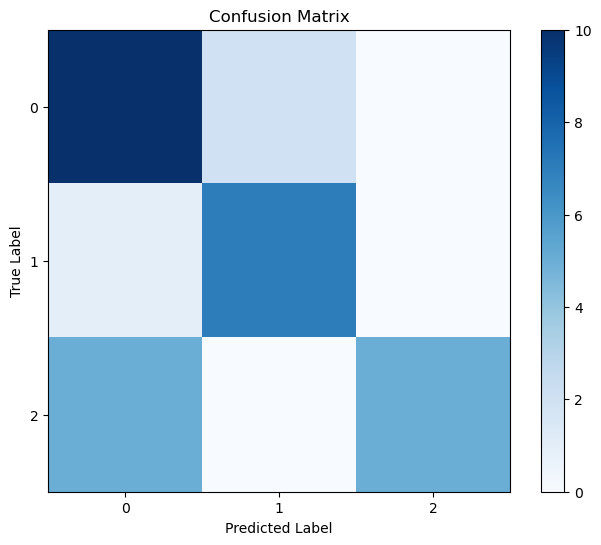

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.78      0.88      0.82         8
           2       1.00      0.50      0.67        10

    accuracy                           0.73        30
   macro avg       0.80      0.74      0.73        30
weighted avg       0.79      0.73      0.73        30

Sensitivity: 0.8750
Specificity: 0.8333
F1 Score: 0.2800


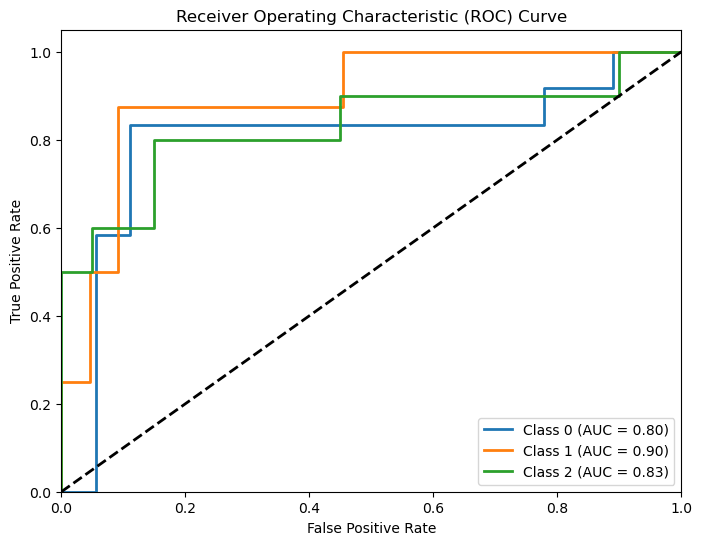

Validation Loss: 0.0288 | Validation Acc: 73.33%


In [79]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Load the model
model = VGG3DComplex(num_classes=3)
model = model.double()  

saved_model_path = 'model_fold_2.pth'  
model.load_state_dict(torch.load(saved_model_path))

model.eval()

criterion = nn.CrossEntropyLoss()

total = 0
correct = 0
val_loss = 0.0
all_true_labels = []
all_predicted_probs = []

with torch.no_grad():
    for data in val_loader:
        inputs, targets = data
        inputs = inputs.double()
        targets = targets.long()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        val_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        all_true_labels.extend(targets.cpu().numpy())
        all_predicted_probs.extend(outputs.softmax(1).cpu().numpy())

val_acc = 100.0 * correct / total
average_val_loss = val_loss / len(val_data)

conf_matrix = confusion_matrix(all_true_labels, np.argmax(all_predicted_probs, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

class_report = classification_report(all_true_labels, np.argmax(all_predicted_probs, axis=1))
print("Classification Report:")
print(class_report)

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * (sensitivity * (1 - specificity)) / (sensitivity + (1 - specificity))
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1_score:.4f}')

all_predicted_probs = np.array(all_predicted_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = num_classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_true_labels, all_predicted_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f'Validation Loss: {average_val_loss:.4f} | Validation Acc: {val_acc:.2f}%')

# Finetuned best_model stats shown in the below cell:
### * Visualizes confusion matrix
### * Computes sensitivity, specificity, and F-1 score
### * Visualizes ROC curve for all classes

Confusion Matrix:
[[10  2  0]
 [ 1  7  0]
 [ 2  3  5]]


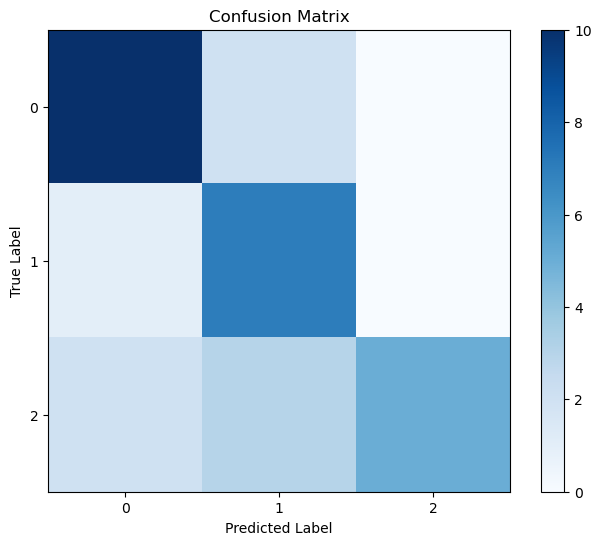

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.58      0.88      0.70         8
           2       1.00      0.50      0.67        10

    accuracy                           0.73        30
   macro avg       0.78      0.74      0.72        30
weighted avg       0.80      0.73      0.73        30

Sensitivity: 0.8750
Specificity: 0.8333
F1 Score: 0.2800


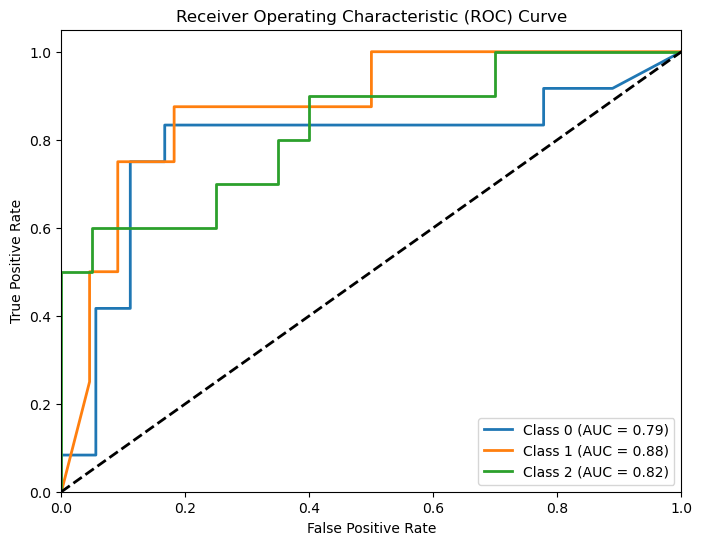

Validation Loss: 0.0283 | Validation Acc: 73.33%


In [88]:

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
model = VGG3DComplex(num_classes=3)
model = model.double()  

saved_model_path = 'best_fine_tuned_model.pth' 
model.load_state_dict(torch.load(saved_model_path))

model.eval()

criterion = nn.CrossEntropyLoss()

total = 0
correct = 0
val_loss = 0.0
all_true_labels = []
all_predicted_probs = []

with torch.no_grad():
    for data in val_loader:
        inputs, targets = data
        inputs = inputs.double()
        targets = targets.long()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        val_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        all_true_labels.extend(targets.cpu().numpy())
        all_predicted_probs.extend(outputs.softmax(1).cpu().numpy())

val_acc = 100.0 * correct / total
average_val_loss = val_loss / len(val_data)

conf_matrix = confusion_matrix(all_true_labels, np.argmax(all_predicted_probs, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


class_report = classification_report(all_true_labels, np.argmax(all_predicted_probs, axis=1))
print("Classification Report:")
print(class_report)

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * (sensitivity * (1 - specificity)) / (sensitivity + (1 - specificity))
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score: {f1_score:.4f}')

all_predicted_probs = np.array(all_predicted_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = num_classes 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_true_labels, all_predicted_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f'Validation Loss: {average_val_loss:.4f} | Validation Acc: {val_acc:.2f}%')